In [48]:
import numpy as np
import pprint
from matplotlib import pyplot as plt
import scipy.io as io
#For BGC
import warnings
import BayesianGeometryCompensation as BGC
from scipy.sparse import SparseEfficiencyWarning
from scipy.integrate import cumtrapz
%matplotlib inline

## Define the problem

In [2]:
def solvable_system(t_sections, n_sections, n_revolutions):
    
    #Convert to 1D array
    t_sections = t_sections.reshape(-1)
    T_sections = np.diff(t_sections)
    
    NM = n_sections * n_revolutions
    n_coeffs = 4
    
    print("There are {} sections and {} rotations (T length = {})".format(n_sections, n_revolutions, len(t_sections)))
    
    if len(t_sections) != NM + 1:
        print("Time is not right, it needs NM + 1 ({}) values, but it has {}.".format(NM + 1, len(t_sections)))
        raise SystemExit
    
    n_unknowns = n_coeffs * NM
    
    #Setup equations
    A = np.zeros((n_unknowns, n_unknowns))
    Bvec = np.zeros((n_unknowns, 1))
    
    #Global counter
    cnt = 0
    
    #Set up the nodal constraints
    coeff_adjust = np.array([1, 1, 1, 1, 1, 0, 0, 0]) #For two interacting splines
    scale_adjust = lambda Tnm: np.array([1, Tnm, Tnm**2, Tnm**3, -1, 0, 0, 0])
    
    for i in range(NM - 1):
        A[cnt, n_coeffs*i:n_coeffs*i + 2 * n_coeffs] = coeff_adjust * scale_adjust(T_sections[i])
        
        cnt += 1
    
    print("Stage 1: {} | {}".format(NM - 1, cnt))
    #Set up the velocity constraints
    coeff_adjust = np.array([0, 1, 1, 1, 0, 1, 0, 0]) #For two interacting splines (active or not)
    scale_adjust = lambda Tnm: np.array([0, 1, 2 * Tnm, 3 * Tnm**2, 0, -1, 0, 0])
    
    for i in range(NM - 1):
        A[cnt, n_coeffs*i:n_coeffs*i + 2 * n_coeffs] = coeff_adjust * scale_adjust(T_sections[i])
        
        cnt += 1
    
    print("Stage 2: {} | {}".format(2 * NM - 2, cnt))
    
    #Set up the acceleration constraints
    coeff_adjust = np.array([0, 0, 1, 1, 0, 0, 1, 0]) #For two interacting splines (active or not)
    scale_adjust = lambda Tnm: np.array([0, 0, 2, 6 * Tnm, 0, 0, -1, 0])
    
    for i in range(NM - 1):
        A[cnt, n_coeffs*i:n_coeffs*i + 2 * n_coeffs] = coeff_adjust * scale_adjust(T_sections[i])
        
        cnt += 1
    
    print("Stage 3: {} | {}".format(3 * NM - 3, cnt))
    #Set up starting point constraint
    A[cnt, 0:n_coeffs] = 1
    cnt += 1
    
    print("Stage 4: {} | {}".format(3 * NM - 2, cnt))
    #Set up the natural cubic spline constraints
    A[cnt, 0:n_coeffs] = np.array([0, 0, 2, 0])
    cnt += 1
    
    print("Stage 5: {} | {}".format(3 * NM - 1, cnt))
    #Set up the natural cubic spline constraints
    A[cnt, -n_coeffs:] = np.array([0, 0, 2, 6 * T_sections[-1]])
    cnt += 1
    
    print("Stage 6: {} | {}".format(3 * NM, cnt))
    #Set up the distance constraints
    adjust_vec = lambda Tnm, Tnm_further: np.concatenate((np.array([0, Tnm, Tnm**2, Tnm**3]), 
                                                          np.zeros(n_coeffs * (n_sections - 1)), 
                                                          -1 * np.array([0, Tnm_further, Tnm_further**2, Tnm_further**3])))
    for i in range(NM - n_sections):
        #print(i, i + M - 1, T_sections[i], T_sections[i + M - 1])
        
        #print(n_coeffs * i, n_coeffs * i + n_coeffs * (n_sections + 1))
        
        start = n_coeffs * i
        end = start + n_coeffs * (n_sections + 1)
        
        #print(start, end)
        #print(len(adjust_vec(T_sections[i], T_sections[i + M - 1])), A[cnt, n_coeffs * i:n_coeffs * i + n_coeffs * (n_sections + 1)].shape)
        A[cnt, start:end] = adjust_vec(T_sections[i], T_sections[i + n_sections])
        cnt += 1
    #pprint.pprint(A)
    
    print("Stage 7: {} | {}".format(4 * NM - n_sections, cnt))
    
    #Set up proportional distance constraints
    T_total = np.sum(T_sections[:n_sections])
    cnt_index = 0
    scale_adjust = lambda Tnm: np.array([0, Tnm, Tnm**2, Tnm**3])
    for i in range(0, n_sections * n_coeffs, n_coeffs):
        
        #Set A
        A[cnt, i:i + n_coeffs] = scale_adjust(T_sections[cnt_index])
        #Set B
        ratio = T_sections[cnt_index] / T_total
        Bvec[cnt, 0] = 2 * np.pi * ratio
        
        cnt += 1
        cnt_index += 1
    
    print("Stage 8: {} | {}".format(4 * NM, cnt))
    
    """
    #Incorrect.
    coeff_adjust = np.array([0, 1, 1, 1]) #For two interacting splines (active or not)
    scale_adjust = lambda Tnm: np.array([0, Tnm, Tnm**2, Tnm**3])
    
    start = 0
    end = n_coeffs
    cnt_index = 0
    for i in range(M):
        
        for j in range(N):
            
            print(i, start, end, cnt_index)
            A[cnt, start:end] = coeff_adjust * scale_adjust(T_sections[cnt_index])
            
            start += n_coeffs
            end += n_coeffs
            cnt_index += 1
        
        Bvec[cnt, 0] = 2 * np.pi
        
        cnt += 1
        
    print(cnt, A.shape)
    plt.matshow(A)
    #plt.show()
    """
    
    #plt.matshow(Bvec)
    #plt.show()
    print(cnt, A.shape)
    #plt.matshow(A)
    
    #plt.matshow(np.linalg.inv(A))
    
    #print(cnt)
    
    x = np.linalg.solve(A, Bvec)
    
    print("Solved the system.")
    #print(x[:, 0])
    thetas = []
    scale_adjust = lambda Tnm: np.array([0, Tnm, Tnm**2, Tnm**3])
    
    for Tnm, i in zip(T_sections, range(0, n_coeffs * NM, n_coeffs)):
        
        param_local = x[i:i + n_coeffs, 0]
        #print("\n", param_local, param_local * scale_adjust(Tnm), "\n")
        thetas.append(np.sum(param_local * scale_adjust(Tnm)))
    
    #print(thetas)
    
    return np.array(thetas)

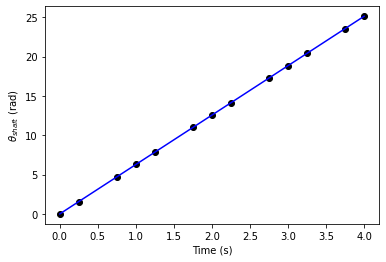

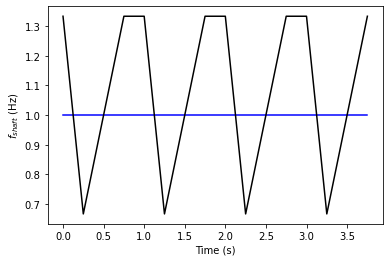

13 12
There are 3 sections and 4 rotations (T length = 13)
Stage 1: 11 | 11
Stage 2: 22 | 22
Stage 3: 33 | 33
Stage 4: 34 | 34
Stage 5: 35 | 35
Stage 6: 36 | 36
Stage 7: 45 | 45
Stage 8: 48 | 48
48 (48, 48)
Solved the system.


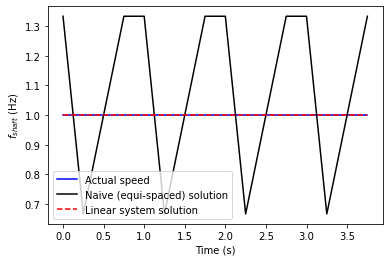

In [49]:
N = 3
M = 4

linear_breakdown = np.array([0] + [1/4, 2/4, 1/4] * M)#np.array([0] + [3/6, 1.5/36, 1.5/6] * M)#

t_scale = np.cumsum(linear_breakdown)
actual_angles = np.cumsum(2 * np.pi * linear_breakdown)
actual_speed = np.diff(actual_angles) / np.diff(t_scale)

#Incorrect speed
incorrect_angles = np.ones_like(t_scale) * 2 * np.pi / N
incorrect_speed = incorrect_angles[:-1] / np.diff(t_scale)

plt.figure()
plt.plot(t_scale, actual_angles, color = "b")
plt.scatter(t_scale, actual_angles, color = "k")
plt.ylabel(r"$\theta_{shaft}$ (rad)")
plt.xlabel("Time (s)")
plt.show()

plt.figure()
plt.plot(t_scale[:-1], actual_speed / (2 * np.pi), color = "b")
plt.plot(t_scale[:-1], incorrect_speed / (2 * np.pi), color = "k")
plt.ylabel(r"$f_{shaft}$ (Hz)")
plt.xlabel("Time (s)")
plt.show()

print(len(t_scale), N * M)
implemented_theta = solvable_system(t_scale, n_sections = N, n_revolutions = M)

implemented_speed = implemented_theta / np.diff(t_scale)

plt.figure()
plt.plot(t_scale[:-1], actual_speed / (2 * np.pi), color = "b", label = "Actual speed")
plt.plot(t_scale[:-1], incorrect_speed / (2 * np.pi), color = "k", label = "Naive (equi-spaced) solution")
plt.plot(t_scale[:-1], implemented_speed / (2 * np.pi), "r--", label = "Linear system solution")
plt.ylabel(r"$f_{shaft}$ (Hz)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

## Recreating Diamond paper

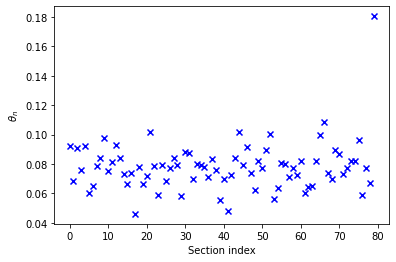

In [50]:
n_ppr = 80

#Create the tacho pulses:
check_pulse_points = 1
cnt_while = 0
while check_pulse_points > 0 and cnt_while < 100:
    pulse_theta = np.random.randn(n_ppr) * (1/n_ppr) + 2 * np.pi /n_ppr

    pulse_theta[-1] = 2 * np.pi - np.sum(pulse_theta[:-1])
    
    check_pulse_points = np.sum(pulse_theta < 0)
    
    cnt_while += 1
    
if cnt_while == 100:
    print("Hit iteration limit (check variance).")
    
    plt.figure()
    plt.scatter(np.arange(len(pulse_theta)), pulse_theta)
    plt.show()

    raise SystemExit

else:
    plt.figure()
    plt.scatter(np.arange(len(pulse_theta)), pulse_theta, color = "b", marker = "x")
    plt.ylabel(r"$\theta_n$")
    plt.xlabel("Section index")
    plt.show()
    
theta_indices = np.cumsum(pulse_theta)

3820 47 3760


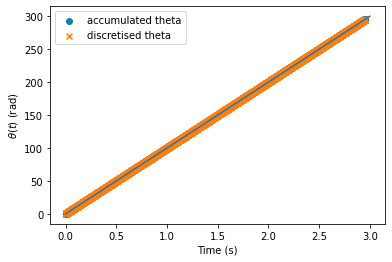

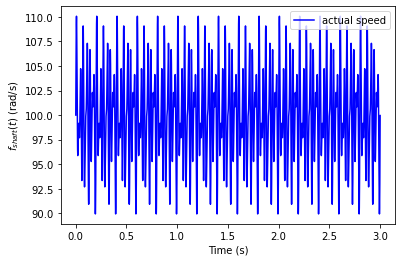

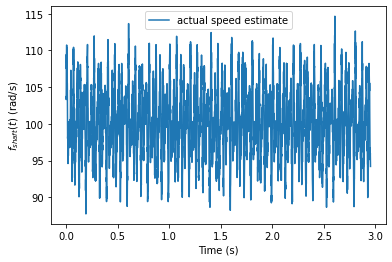

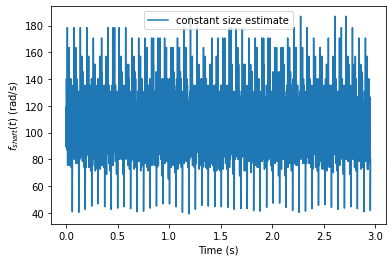

There are 80 sections and 47 rotations (T length = 3761)
Stage 1: 3759 | 3759
Stage 2: 7518 | 7518
Stage 3: 11277 | 11277
Stage 4: 11278 | 11278
Stage 5: 11279 | 11279
Stage 6: 11280 | 11280
Stage 7: 14960 | 14960
Stage 8: 15040 | 15040
15040 (15040, 15040)
Solved the system.


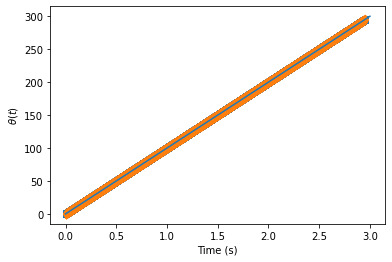

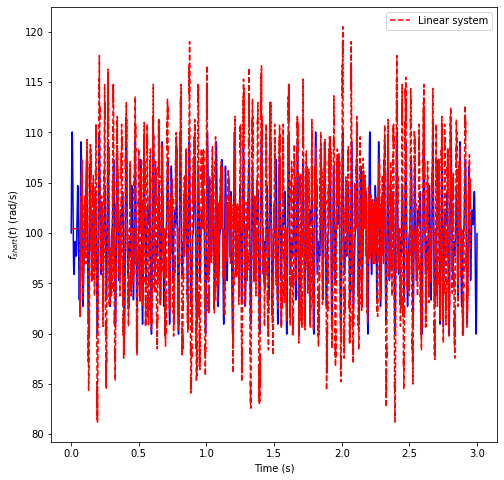

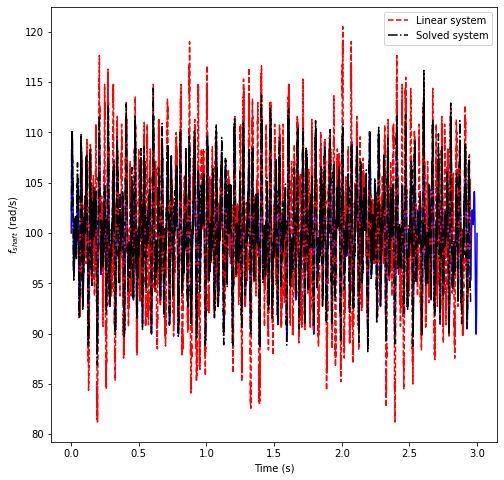

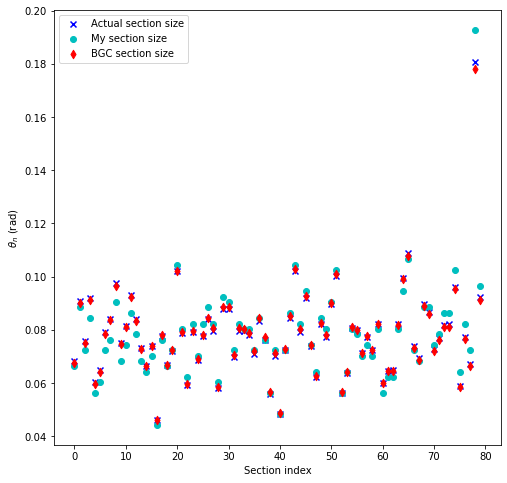

Error (mine) =  2.156744336911537
Error (BGC) =  1.989911000434133


In [54]:
tend = 3
Fs = 50e3
t = np.arange(0, tend, 1/Fs)

# actual_speed = 100 + 10 * t
#actual_speed = 100 + 5 * np.sin(2 * np.pi * 30 * t)
#actual_speed = 100 + 10 * t + 5 * np.sin(2 * np.pi * 30 * t)
actual_speed = 100 + 5 * np.sin(2 * np.pi * 30 * t) + 4 * np.sin(2 * np.pi * 45 * t) + 2 * np.sin(2 * np.pi * 20 * t)
# actual_speed = 100 + np.zeros_like(t)

theta_shaft = cumtrapz(actual_speed, t, initial = 0)

cnt_rot = 0
cnt_index = 0
tacho_indices = []

for cnt_i, i in enumerate(theta_shaft):
    
    if i - 2 * np.pi * cnt_rot >= theta_indices[cnt_index]:
        cnt_index += 1
        tacho_indices.append(cnt_i)
        
    
    if cnt_index == len(theta_indices): 
        cnt_index = 0
        cnt_rot += 1
    
print(len(tacho_indices), cnt_rot, n_ppr * cnt_rot)
#Scale down the indices
#cnt_rot -= 1
tacho_indices = tacho_indices[:n_ppr*cnt_rot + 1]
dt = np.diff(t[tacho_indices])

accumulative_tile = np.array([]) #Actual indices
repeated_tile = np.tile(np.roll(pulse_theta, n_ppr - 1), cnt_rot) #Use the roll as the theta indices do not start at zero.

for i in range(cnt_rot):
    accumulative_tile = np.concatenate((accumulative_tile, 2 * np.pi * i + theta_indices))
    
plt.figure()
plt.plot(t, theta_shaft)
plt.scatter(t[tacho_indices][:-1], accumulative_tile, marker = "o", label = "accumulated theta")
plt.scatter(t[tacho_indices], theta_shaft[tacho_indices], marker = "x", label = 'discretised theta')
plt.ylabel(r"$\theta(t)$ (rad)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, actual_speed, color = "b", label = "actual speed")
plt.ylabel(r"$f_{shaft}(t)$ (rad/s)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t[tacho_indices][:-1], repeated_tile / dt, label = "actual speed estimate")
plt.ylabel(r"$f_{shaft}(t)$ (rad/s)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

plt.figure()
#plt.plot(t, actual_speed, color = "b")
plt.plot(t[tacho_indices][:-1], (2 * np.pi / n_ppr) / np.diff(t[tacho_indices]), label = "constant size estimate")
plt.ylabel(r"$f_{shaft}(t)$ (rad/s)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

implemented_theta = solvable_system(t[tacho_indices], n_sections = n_ppr, n_revolutions = cnt_rot)

implemented_speed = implemented_theta / dt


plt.figure()
plt.plot(t, theta_shaft)
plt.scatter(t[tacho_indices], theta_shaft[tacho_indices], marker = "x", label = "actual indices")
plt.scatter(t[tacho_indices][:-1], np.cumsum(implemented_theta), marker = "d", label = "accumulated uniquely solvable indices")
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Time (s)")
plt.show()

plt.figure(figsize = (8, 8))
plt.plot(t, actual_speed, color = "b")
plt.plot(t[tacho_indices][:-1], implemented_speed, "r--", label = "Linear system")
plt.ylabel(r"$f_{shaft}(t)$ (rad/s)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

#BGC: 
#implemented_theta = solvable_system(t[tacho_indices], n_sections = N_local, n_revolutions = cnt_rot)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", SparseEfficiencyWarning)
    spacing = BGC.PerformBayesianGeometryCompensation(t[tacho_indices], n_ppr, cnt_rot, )

spacing_extended = np.tile(spacing, cnt_rot)
BGC_speed = spacing_extended / dt
plt.figure(figsize = (8, 8))
plt.plot(t, actual_speed, color = "b")
#plt.plot(t[tacho_indices][:-1], implemented_speed / (2 * np.pi), "r--", label = "Solved system")
plt.plot(t[tacho_indices][:-1], implemented_speed, "r--", label = "Linear system")
plt.plot(t[tacho_indices][:-1], BGC_speed, "k-.", label = "Solved system")
plt.ylabel(r"$f_{shaft}$ (rad/s)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

plt.figure(figsize = (8, 8))
plt.scatter(np.arange(n_ppr), np.roll(pulse_theta, shift = n_ppr - 1), marker = "x", color = "b", label = "Actual section size")
plt.scatter(np.arange(n_ppr), implemented_theta[:n_ppr], marker = "o", color = "c", label = "My section size")
plt.scatter(np.arange(n_ppr), spacing, marker = "d", color = "r", label = "BGC section size")
plt.legend()
plt.xlabel("Section index")
plt.ylabel(r"$\theta_n$ (rad)")
plt.show()

print("Error (mine) = ", np.sum((np.tile(pulse_theta, cnt_rot) - implemented_theta)**2))
print("Error (BGC) = ", np.sum((np.tile(pulse_theta, cnt_rot) - spacing_extended)**2))



# Load in an actual signal

In [31]:
def PulsePoints(Tacho, TimeTacho, Threshold, Slope):
        
    Sign = np.sign(Tacho - Threshold)
    GradSign = np.diff(Sign)
    Pos = []

    for Cnt, i in enumerate(GradSign):

        if Slope > 0:
            if i > 0.8:

                Pos.append(Cnt)

        if Slope < 0:
            if i < -0.8:
                Pos.append(Cnt)

    Pos = np.array(Pos)

    return Pos, TimeTacho[Pos]


In [32]:
data_mat = io.loadmat("D:/PhD_Files/Datasets/Gearbox/Exp1H/Exp1H_R0001.mat")

ppr = 88
Fs = 25.6e3
Fs_tacho = 51.2e3
slope = 1
trig_level = -0.9
Tend = 20

tacho = data_mat["Track7"][0, :]
time_tacho = np.arange(0, len(tacho) / Fs_tacho + 1/Fs_tacho, 1/Fs_tacho)

pos, time_pos = PulsePoints(tacho, time_tacho, trig_level, slope)

n_rev = len(pos) // ppr

time_pos_used = time_pos[:n_rev*ppr + 1]

implemented_theta = solvable_system(time_pos_used, n_sections = ppr, n_revolutions = n_rev)

There are 88 sections and 47 rotations (T length = 4137)
Stage 1: 4135 | 4135
Stage 2: 8270 | 8270
Stage 3: 12405 | 12405
Stage 4: 12406 | 12406
Stage 5: 12407 | 12407
Stage 6: 12408 | 12408
Stage 7: 16456 | 16456
Stage 8: 16544 | 16544
16544 (16544, 16544)
Solved the system.


## Compare to BGC

In [33]:
print("There are {} revs".format(n_rev))
with warnings.catch_warnings():
    warnings.simplefilter("ignore", SparseEfficiencyWarning)
    spacing = BGC.PerformBayesianGeometryCompensation(time_pos_used, ppr, n_rev)

spacing_extended = np.tile(spacing, n_rev)
#spacing_extended = np.concatenate( (spacing_extended, spacing[0:len(time_pos_used) % ppr]) )


There are 47 revs


## Visualise

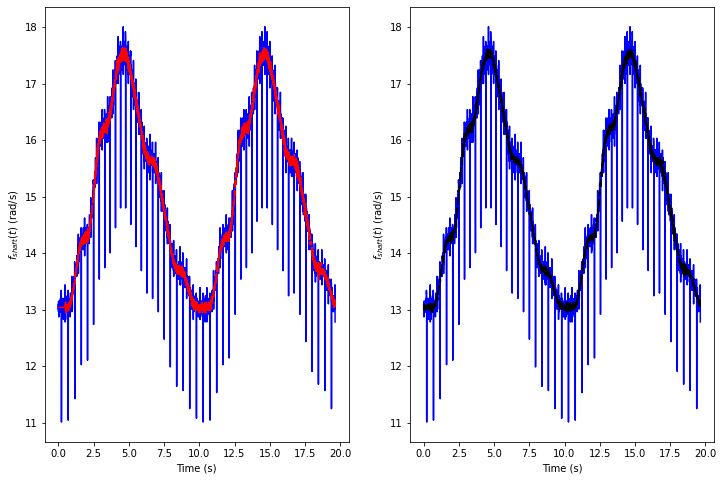

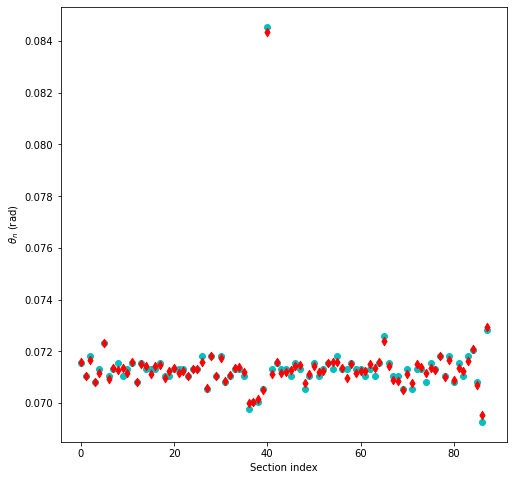

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].plot(time_pos_used[:-1], 2 * np.pi /ppr / np.diff(time_pos_used), color = "b", label = "Estimated profile (Naive)")
ax[0].plot(time_pos_used[:-1], implemented_theta / np.diff(time_pos_used), "r--", label = "Estimated profile (Linear system)")

ax[1].plot(time_pos_used[:-1], 2 * np.pi /ppr / np.diff(time_pos_used), color = "b", label = "Estimated profile (Naive)")
ax[1].plot(time_pos_used[:-1], spacing_extended / np.diff(time_pos_used), "k--", label = "Estimated profile (BGC)")

for axs in ax:
    axs.set_ylabel(r"$f_{shaft}(t)$ (rad/s)")
    axs.set_xlabel("Time (s)")
plt.show()

plt.figure(figsize = (8, 8))
plt.scatter(np.arange(len(implemented_theta[:ppr])), implemented_theta[:ppr], marker = "o", color = "c", label = "My section size")
plt.scatter(np.arange(len(spacing)), spacing, marker = "d", color = "r", label = "BGC section size")
plt.xlabel("Section index")
plt.ylabel(r"$\theta_n$ (rad)")
plt.show()

#print("Error (mine) = ", np.sum(np.tile(pulse_theta, n_rev) - implemented_theta))
#print("Error (BGC) = ", np.sum(np.tile(pulse_theta, n_rev) - spacing_extended))